# RD

"Quasi-experiments"では各実験単位 (細胞、人々、企業、学校、州など) を処置群または対照グループにランダムに割り当てることが難しい状況を考える。
ランダムな割り当てを行うことができないため、処置群と対象群の間の差異が介入によるものであり、交絡因子によるものではないと主張することが難しい。

回帰不連続計画では実験単位のユニットの割り当てはランダムではなく、閾値基準に基づいて選択される。

## SHARP RD

完全に閾値によって各ユニットの群の振り分けが決定される場合

In [43]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

In [44]:
# define true parameters
threshold = 60.0
treatment_effect = 8
N = 1000
sd = 5  # represents change between pre and post test with zero measurement error

# No measurement error, but random change from pre to post
df = (
    pd.DataFrame.from_dict({"x": rng.normal(loc=60, scale= 10, size=N)})
    .assign(treated=lambda x: x.x > threshold)
    .assign(y=lambda x: x.x + rng.normal(loc=0, scale=sd, size=N) + treatment_effect * x.treated)
)

df

,x,treated,y
0,50.108786,False,55.774037
1,56.322133,False,47.761604
2,72.879253,True,81.845691
3,61.939744,True,73.888748
4,69.202309,True,82.362216
...,...,...,...
995,47.532742,False,42.983763
996,60.904278,True,67.512297
997,63.706578,True,65.067224
998,49.367324,False,55.557315


<Axes: xlabel='observed $x$ (pre-test)', ylabel='observed $y$ (post-test)'>

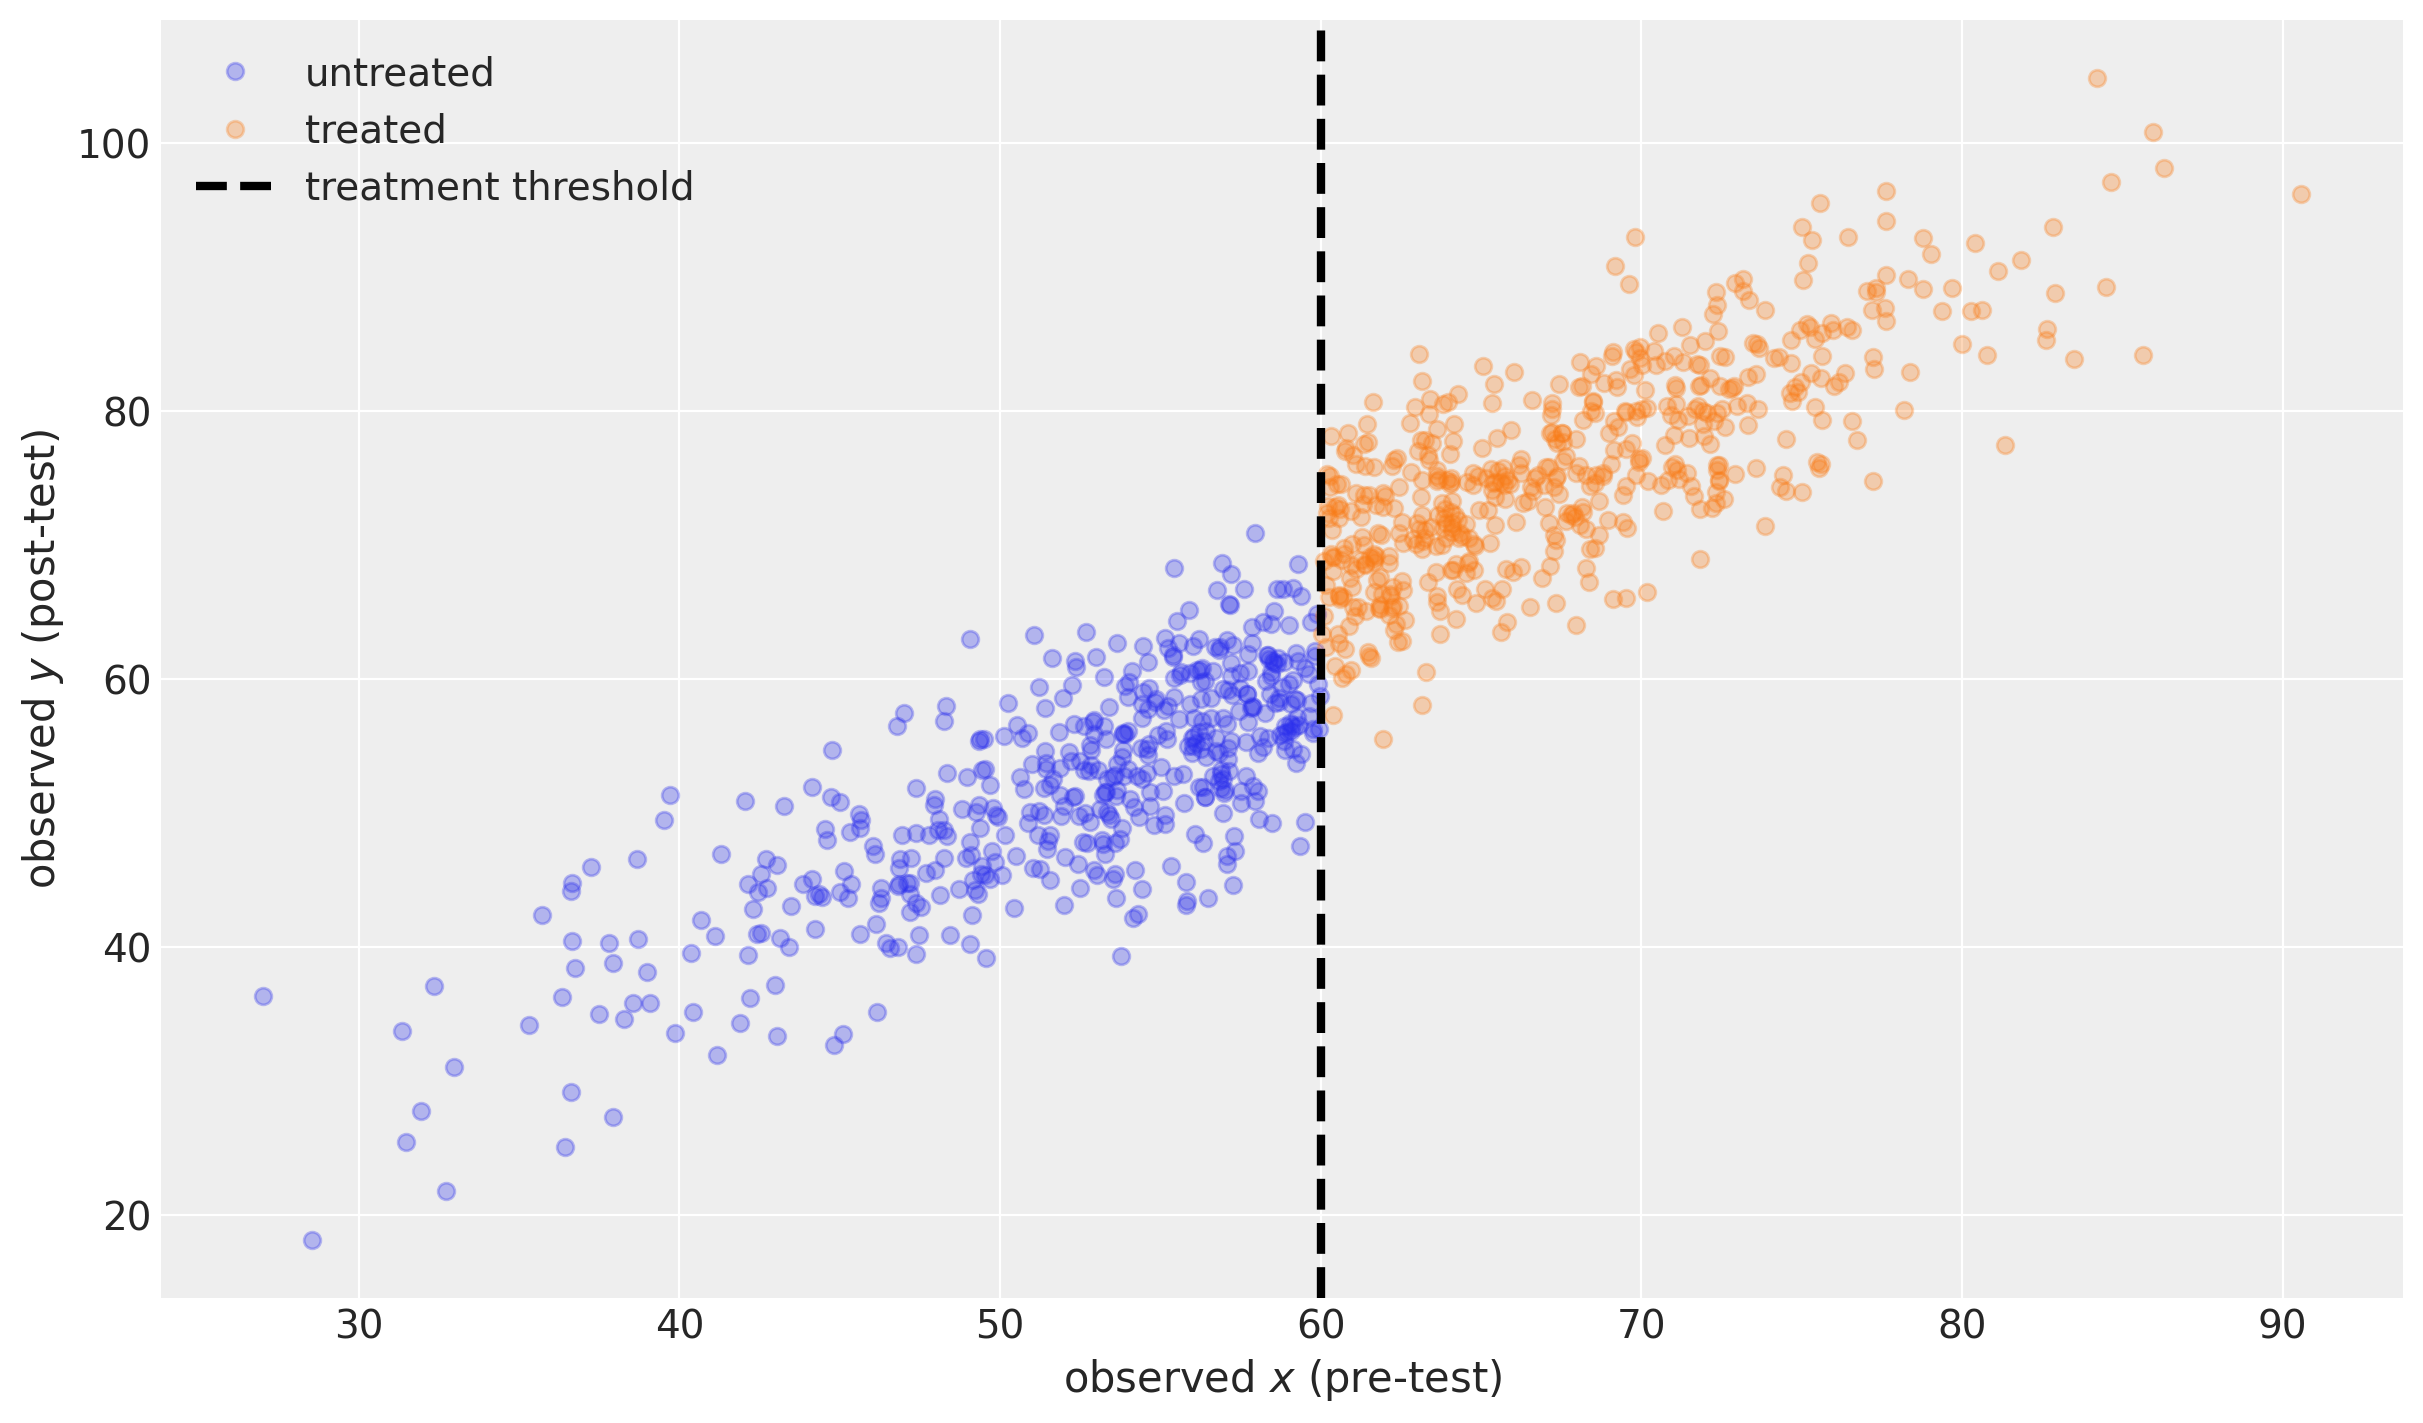

In [45]:
def plot_data(df):
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(df.x[~df.treated], df.y[~df.treated], "o", alpha=0.3, label="untreated")
    ax.plot(df.x[df.treated], df.y[df.treated], "o", alpha=0.3, label="treated")
    ax.axvline(x=threshold, color="k", ls="--", lw=3, label="treatment threshold")
    ax.set(xlabel=r"observed $x$ (pre-test)", ylabel=r"observed $y$ (post-test)")
    ax.legend()
    return ax


plot_data(df)

$$
\begin{split}
\begin{aligned}
\Delta & \sim \text{Cauchy}(0, 1) \\
\sigma & \sim \text{HalfNormal}(0, 1) \\
\mu & = x_i + \underbrace{\Delta \cdot treated_i}_{\text{treatment effect}} \\
y_i & \sim \text{Normal}(\mu, \sigma)
\end{aligned}
\end{split}
$$

In [46]:
with pm.Model() as model:
    x = pm.MutableData("x", df.x, dims="obs_id")
    treated = pm.MutableData("treated", df.treated, dims="obs_id")
    sigma = pm.HalfNormal("sigma", 1)
    delta = pm.Cauchy("effect", alpha=0, beta=1)
    mu = pm.Deterministic("mu", x + (delta * treated), dims="obs_id")
    pm.Normal("y", mu=mu, sigma=sigma, observed=df.y, dims="obs_id")

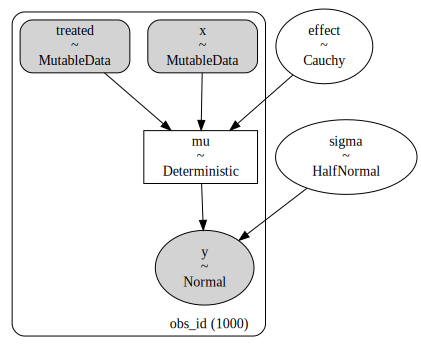

In [47]:
pm.model_to_graphviz(model)

In [48]:
# 推論
with model:
    idata = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, effect]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


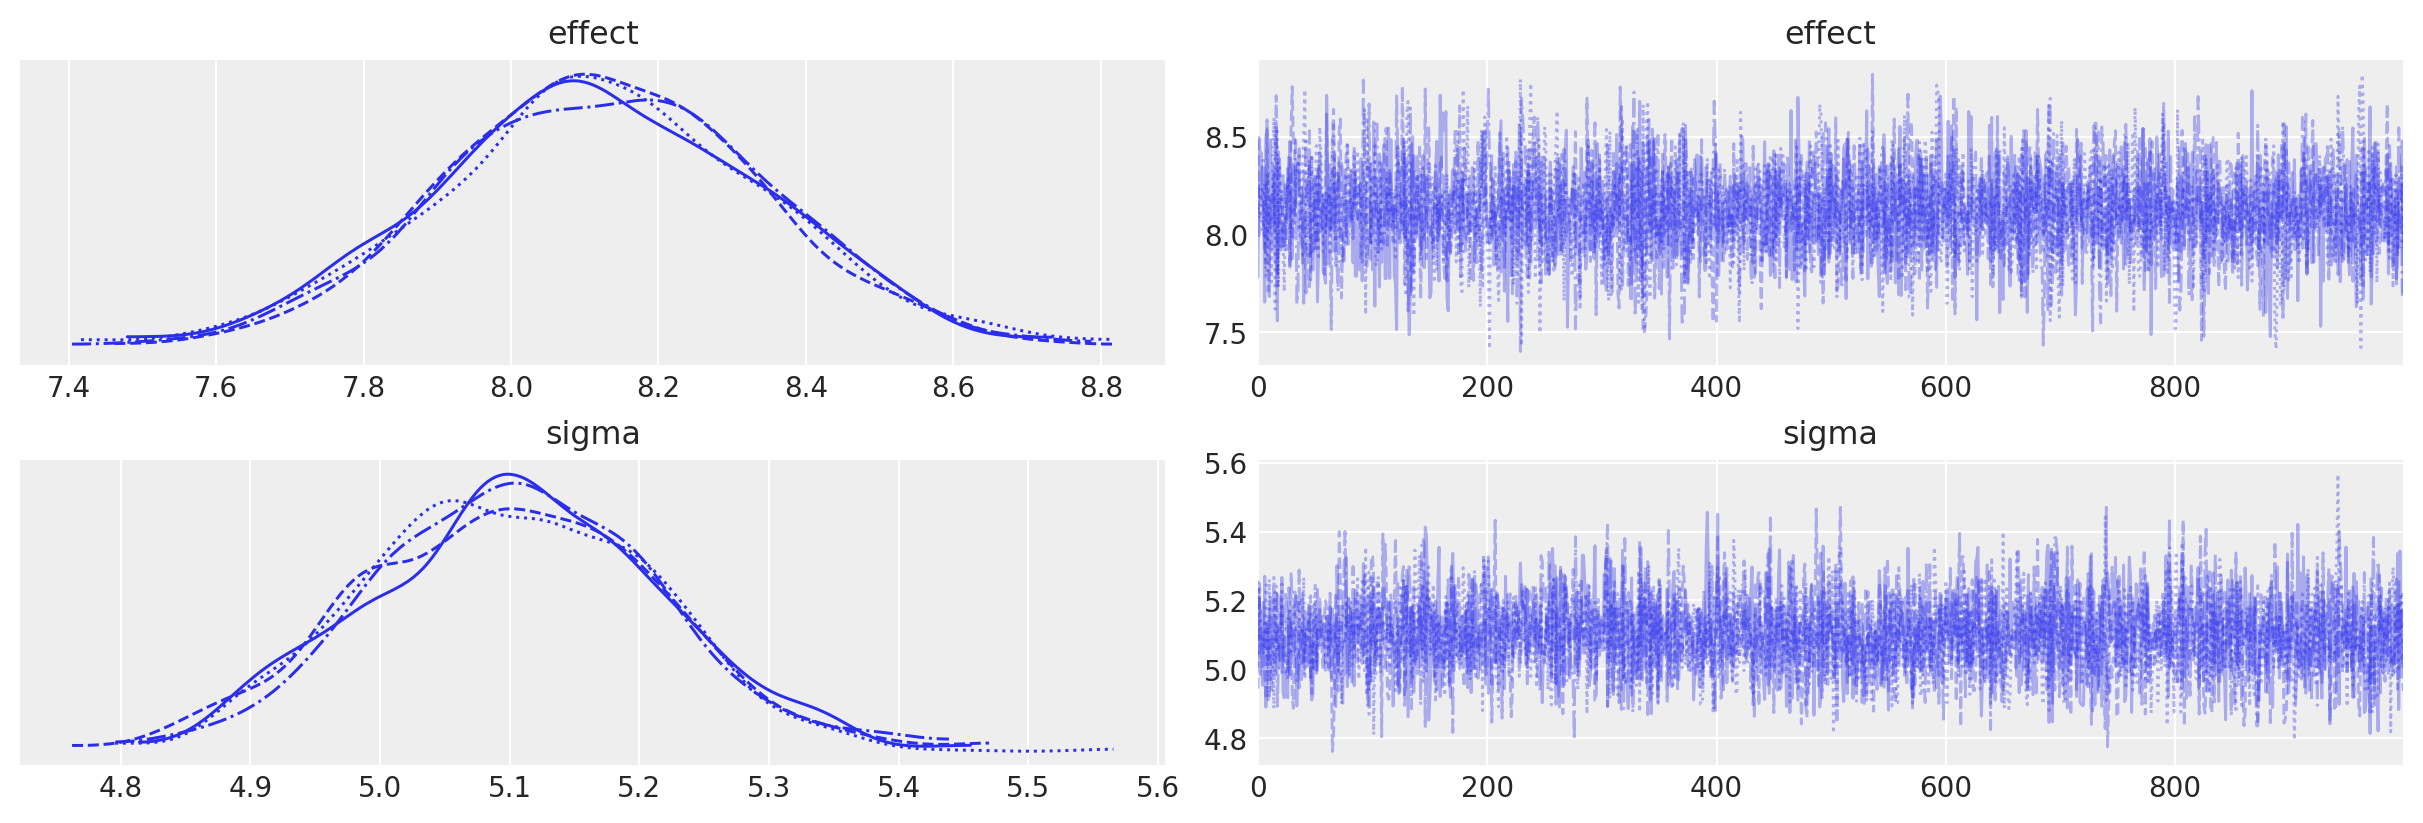

In [49]:
az.plot_trace(idata, var_names=["effect", "sigma"]);

array([<Axes: title={'center': 'effect'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

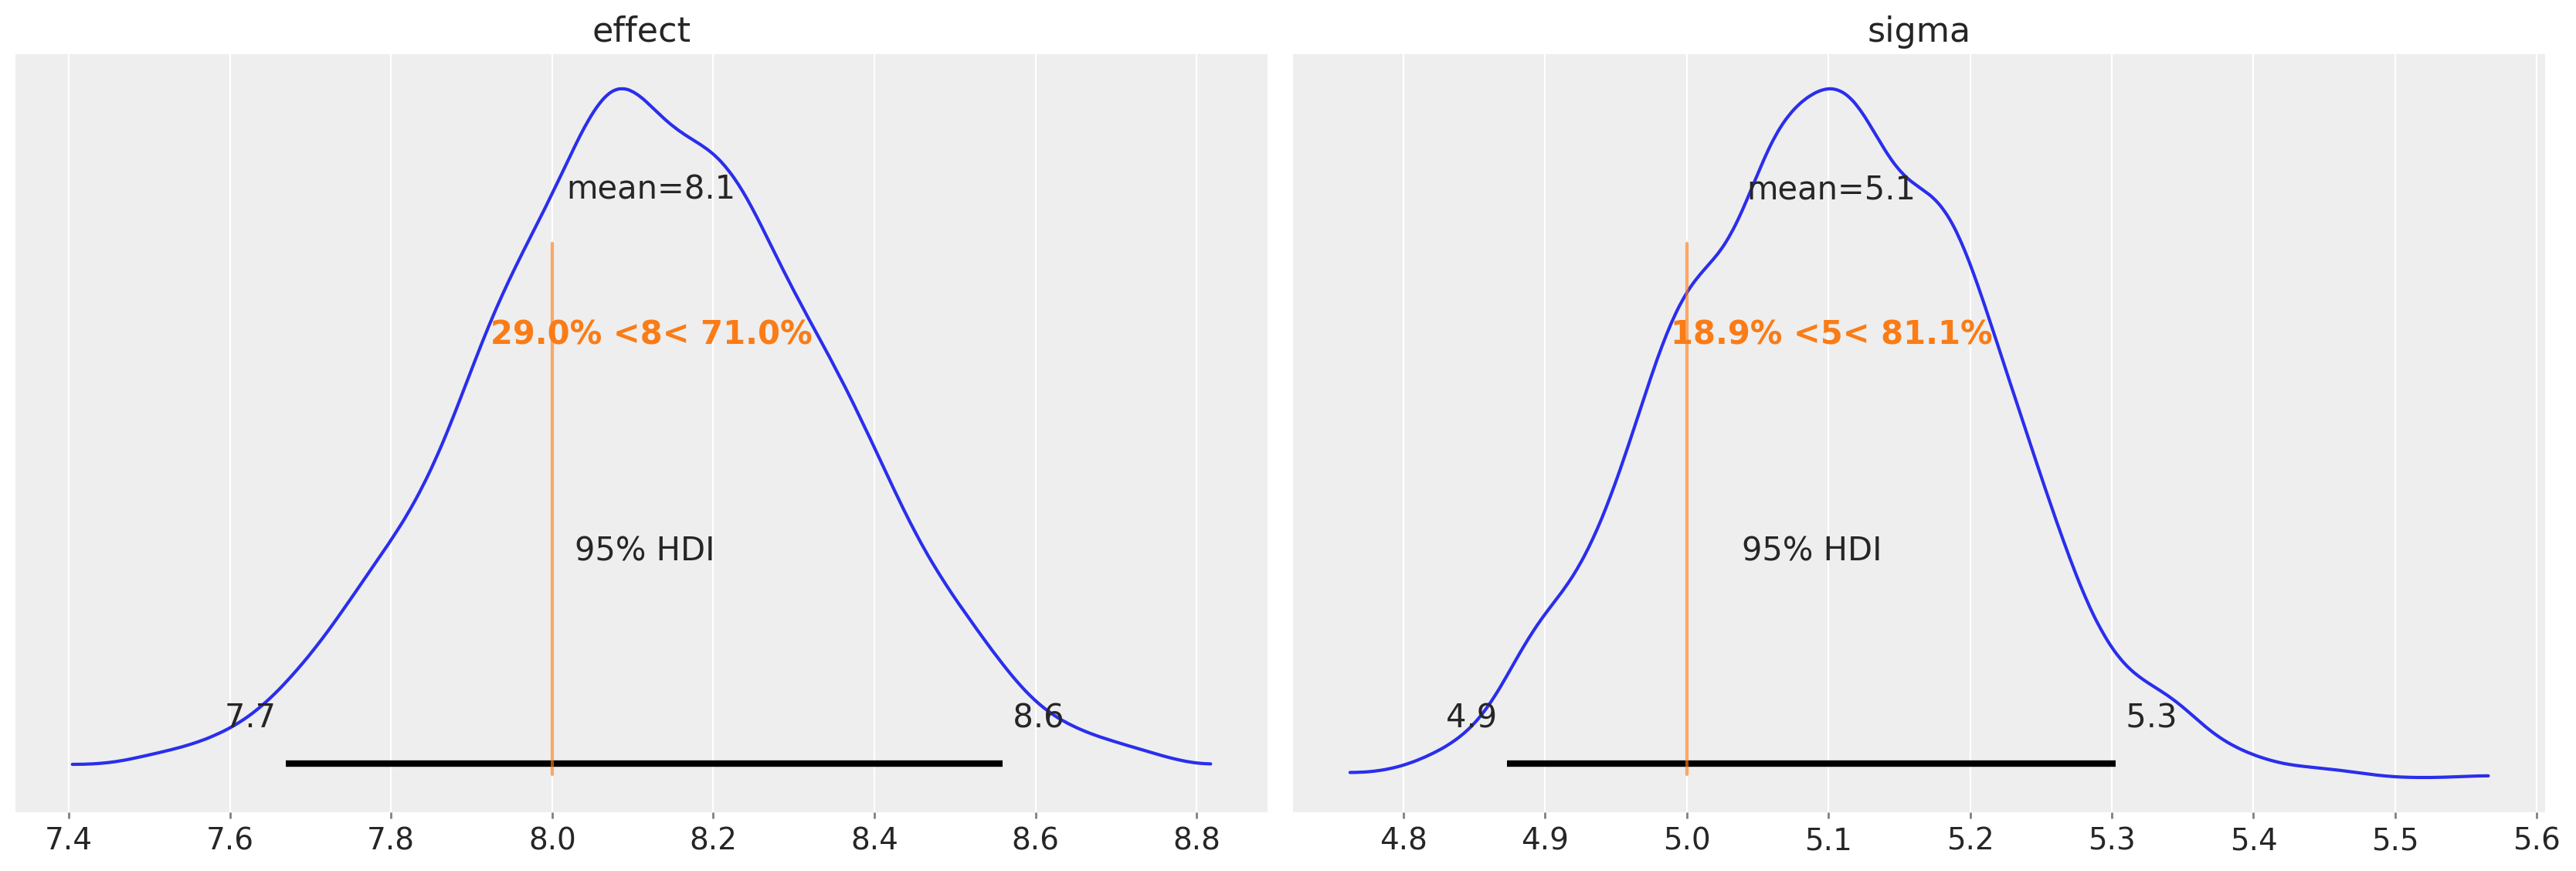

In [50]:
az.plot_posterior(
    idata, var_names=["effect", "sigma"], ref_val=[treatment_effect, sd], hdi_prob=0.95
)

Sampling: [y]


Sampling: [y]


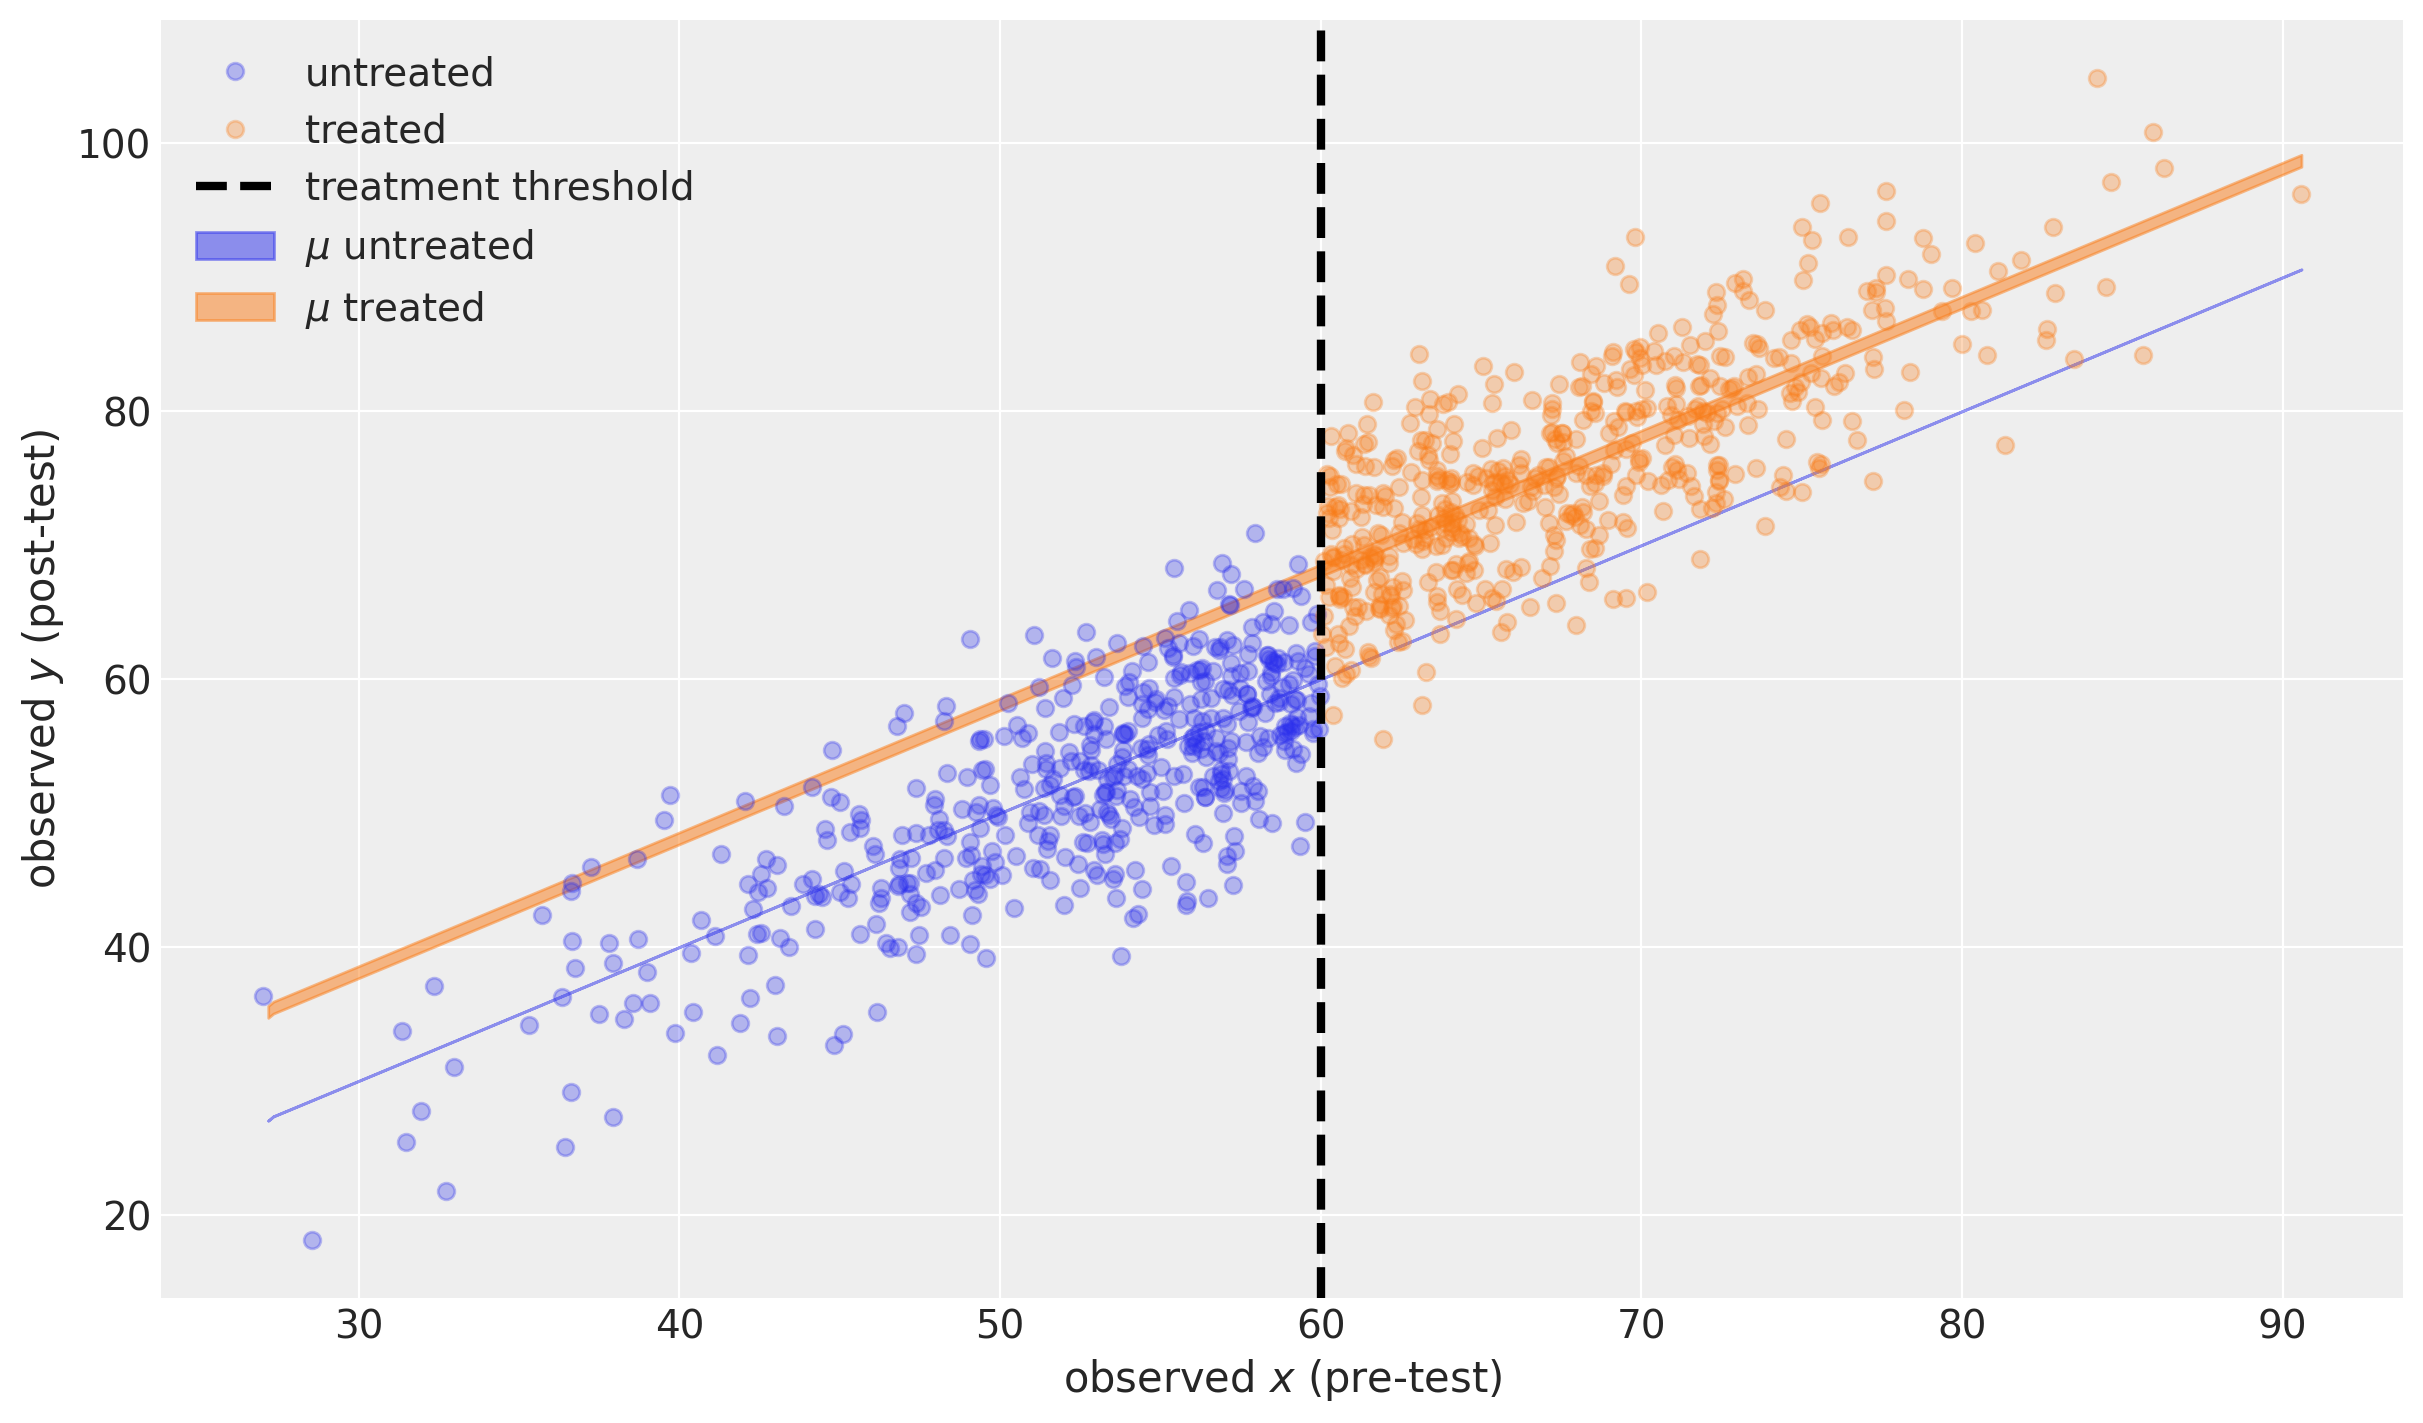

In [51]:
# MODEL EXPECTATION WITHOUT TREATMENT ------------------------------------
# probe data
_x = np.linspace(np.min(df.x), np.max(df.x), 500)
_treated = np.zeros(_x.shape)

# posterior prediction (see technical note above)
with model:
    pm.set_data({"x": _x, "treated": _treated})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])

# plotting
ax = plot_data(df)
az.plot_hdi(
    _x,
    ppc.posterior_predictive["mu"],
    color="C0",
    hdi_prob=0.95,
    ax=ax,
    fill_kwargs={"label": r"$\mu$ untreated"},
)


# MODEL EXPECTATION WITH TREATMENT ---------------------------------------
# probe data
_x = np.linspace(np.min(df.x), np.max(df.x), 500)
_treated = np.ones(_x.shape)

# posterior prediction (see technical note above)
with model:
    pm.set_data({"x": _x, "treated": _treated})
    ppc = pm.sample_posterior_predictive(idata, var_names=["mu", "y"])

# plotting
az.plot_hdi(
    _x,
    ppc.posterior_predictive["mu"],
    color="C1",
    hdi_prob=0.95,
    ax=ax,
    fill_kwargs={"label": r"$\mu$ treated"},
)
ax.legend()

## FUZZY RD